# Paintings by Style: CLIP + UMAP Scatter

This notebook mirrors the Picasso embedding plot, but uses `data/paintings-by-style.csv`. Points are colored by `style`, and hover shows artist, title, and year.

In [2]:
from pathlib import Path
import os
import pandas as pd
import numpy as np
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
from sklearn.preprocessing import MinMaxScaler
import umap
import plotly.express as px
from plotly.colors import qualitative as pq
from IPython.display import display
try:
    from tqdm import tqdm
except Exception:
    tqdm = lambda x, **k: x

_HERE = Path(__file__).resolve().parent if "__file__" in globals() else Path.cwd()
_ROOT = _HERE.parent
DATA_DIR = _ROOT / 'data' / 'paintings-by-style'
CSV_PATH = _ROOT / 'data' / 'paintings-by-style.csv'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

df = pd.read_csv(CSV_PATH)
# Normalize column names for easier access
df = df.rename(columns={
    'directory+filename': 'rel_path',
    'painting title': 'title',
    'year of painting': 'year'
})
# Derive artist from rel_path: style/artist/filename
def extract_artist(p: str) -> str:
    parts = str(p).split('/')
    return parts[1] if len(parts) >= 2 else ''

df['artist'] = df['rel_path'].astype(str).map(extract_artist)
df['image_path'] = df['rel_path'].apply(lambda p: str(DATA_DIR / p))
df['year'] = pd.to_numeric(df['year'], errors='coerce')
print(f'Loaded {len(df)} rows from {CSV_PATH.name}')
display(df.head())

Loaded 140 rows from paintings-by-style.csv


,rel_path,title,year,style,artist,image_path
0,abstract-expressionism/kline/1950-chief.jpg,chief,1950,abstract-expressionism,kline,/Users/roryashton/coding-repositories/ml-art-r...
1,abstract-expressionism/kline/1954-number-2.jpg,number 2,1954,abstract-expressionism,kline,/Users/roryashton/coding-repositories/ml-art-r...
2,abstract-expressionism/kline/1955-white-forms.jpg,white forms,1955,abstract-expressionism,kline,/Users/roryashton/coding-repositories/ml-art-r...
3,abstract-expressionism/kline/1961-le-gros.jpg,le gros,1961,abstract-expressionism,kline,/Users/roryashton/coding-repositories/ml-art-r...
4,abstract-expressionism/kline/1961-meryon.jpg,meryon,1961,abstract-expressionism,kline,/Users/roryashton/coding-repositories/ml-art-r...


In [3]:
# Compute CLIP embeddings
clip_model = CLIPModel.from_pretrained('openai/clip-vit-base-patch32').to(DEVICE)
clip_processor = CLIPProcessor.from_pretrained('openai/clip-vit-base-patch32')
clip_model.eval()

def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    return clip_processor(images=image, return_tensors='pt')['pixel_values']

embeddings = []
failed = []
for p in tqdm(df['image_path'], desc='Extracting CLIP embeddings'):
    try:
        pixel_values = preprocess_image(p).to(DEVICE)
        with torch.no_grad():
            emb = clip_model.get_image_features(pixel_values=pixel_values)
        embeddings.append(emb.squeeze().cpu().numpy())
    except Exception as e:
        failed.append((p, str(e)))
        embeddings.append(np.zeros(512, dtype=np.float32))

if failed:
    print(f'Failed to embed {len(failed)} images (filled with zeros).')

emb_matrix = np.vstack(embeddings)
reducer = umap.UMAP(random_state=42)
embedding_2d = reducer.fit_transform(emb_matrix)
df['x'] = embedding_2d[:, 0]
df['y'] = embedding_2d[:, 1]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Extracting CLIP embeddings: 100%|██████████| 140/140 [00:09<00:00, 14.96it/s]
/Users/roryashton/coding-repositories/ml-art-representation/venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [4]:
# Interactive scatter colored by style with informative hover
# Enforce equal axis range for a square canvas
xmin, xmax = df['x'].min(), df['x'].max()
ymin, ymax = df['y'].min(), df['y'].max()
xc, yc = (xmin + xmax) / 2.0, (ymin + ymax) / 2.0
half = max(xmax - xmin, ymax - ymin) / 2.0
half = 0.5 if half <= 0 else half

# Use a vivid, categorical color map per style
_style_cats = pd.Categorical(df['style']).categories.tolist()
_palette = (pq.Dark24 + pq.Vivid + pq.Bold)
_color_map = {cat: _palette[i % len(_palette)] for i, cat in enumerate(_style_cats)}

fig = px.scatter(
    df, x='x', y='y', color='style', color_discrete_map=_color_map,
    hover_name='title',
    hover_data={'artist': True, 'year': True, 'style': False, 'rel_path': False},
    width=900, height=900,
)
fig.update_layout(
    title='CLIP Embedding of Paintings by Style (UMAP Projection)',
    template='plotly_white',
)
fig.update_xaxes(range=[xc - half, xc + half], visible=True, constrain='domain')
fig.update_yaxes(scaleanchor='x', scaleratio=1, visible=True, constrain='domain')

# Enforce equal aspect and square grid cells by using identical ranges and tick steps
import math
def nice_dtick(range_span: float, target_ticks: int = 8) -> float:
    raw = max(range_span / max(target_ticks, 1), 1e-9)
    mag = 10 ** math.floor(math.log10(raw))
    norm = raw / mag
    if norm <= 1: base = 1
    elif norm <= 2: base = 2
    elif norm <= 5: base = 5
    else: base = 10
    return base * mag

rng = 2 * half
dt = nice_dtick(rng, target_ticks=8)

fig.update_layout(
    width=900,
    height=900,
    template='plotly_white',
    legend=dict(
        title='Style',
        orientation='v',
        yanchor='top',
        y=0.99,
        xanchor='left',
        x=1.02,
        bgcolor='rgba(255, 255, 255, 0.9)',
        bordercolor='rgba(0, 0, 0, 0.1)',
        borderwidth=1,
    ),
    margin=dict(t=80, r=220, b=60, l=60),
)
fig.update_xaxes(range=[xc - half, xc + half], tickmode='linear', dtick=dt, constrain='domain')
fig.update_yaxes(range=[yc - half, yc + half], tickmode='linear', dtick=dt, scaleanchor='x', scaleratio=1, constrain='domain')
fig.show()

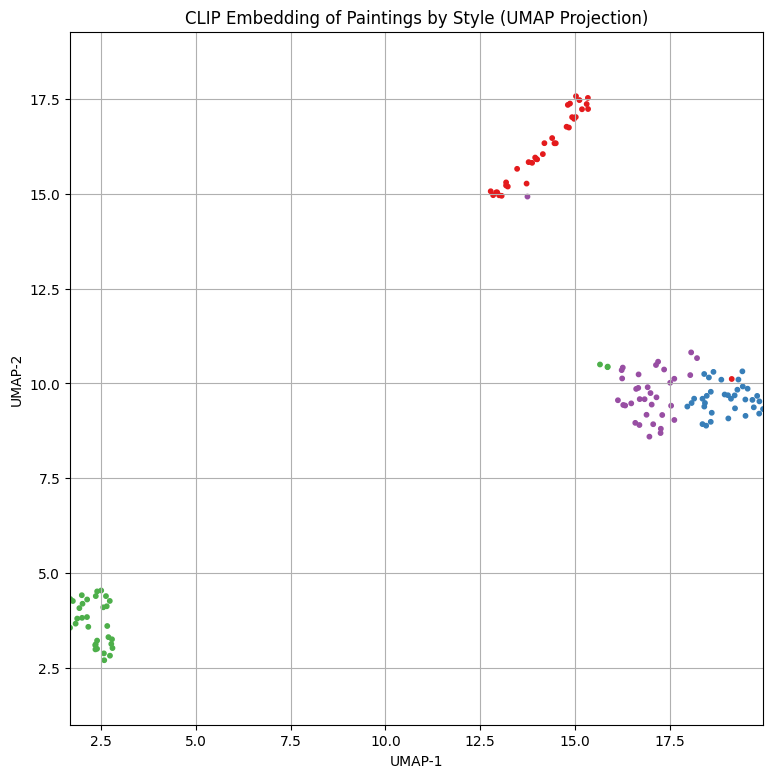

In [5]:
# Matplotlib reference with guaranteed square grid cells (mirrors Picasso notebook)
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(9, 9))
# Map styles to distinct colors
styles = pd.Categorical(df['style'])
# High-contrast categorical palette (ColorBrewer Set1)
base = sns.color_palette('Set1', n_colors=8)
palette = [base[i % len(base)] for i in range(len(styles.categories))]
color_map = dict(zip(styles.categories, palette))
colors = df['style'].map(color_map)
scatter = ax.scatter(df['x'], df['y'], c=colors, s=10)
legend_handles = [
    Line2D(
        [0], [0],
        marker='o', linestyle='None', markersize=7,
        markerfacecolor=color_map[style], markeredgecolor=color_map[style],
        label=style,
    )
    for style in styles.categories
]
ax.legend(
    handles=legend_handles,
    title='Style',
    loc='upper left',
    bbox_to_anchor=(1.02, 1),
    borderaxespad=0.0,
    frameon=True,
)
fig.subplots_adjust(right=0.8)
ax.grid(True)

xmin, xmax = df['x'].min(), df['x'].max()
ymin, ymax = df['y'].min(), df['y'].max()
xc, yc = (xmin + xmax) / 2.0, (ymin + ymax) / 2.0
half = max(xmax - xmin, ymax - ymin) / 2.0
half = 0.5 if half <= 0 else half
ax.set_xlim(xc - half, xc + half)
ax.set_ylim(yc - half, yc + half)
ax.set_aspect('equal', adjustable='box')
try:
    ax.set_box_aspect(1)
except Exception:
    pass
ax.set_title('CLIP Embedding of Paintings by Style (UMAP Projection)')
ax.set_xlabel('UMAP-1')
ax.set_ylabel('UMAP-2')
plt.show()


In [6]:
# Silhouette score for style clusters in CLIP space
from sklearn.metrics import silhouette_score, silhouette_samples
import numpy as np

# Full CLIP embedding space
X_full = np.vstack(embeddings) if 'embeddings' in locals() else None
labels = df['style'].astype(str).values
if X_full is not None and len(X_full) == len(df):
    sil_full = silhouette_score(X_full, labels)
    print(f'Average silhouette (CLIP embedding): {sil_full:.4f}')
    s_full = silhouette_samples(X_full, labels)
    by_style_full = (
        pd.DataFrame({'style': df['style'].values, 'silhouette': s_full})
        .groupby('style')['silhouette']
        .mean()
        .sort_values(ascending=False)
    )
    display(by_style_full)
else:
    print('CLIP embedding matrix not available for silhouette score.')



Average silhouette (CLIP embedding): 0.1372


style
analytical-cubism         0.337457
abstract-expressionism    0.125270
impressionism             0.095141
surrealism               -0.009250
Name: silhouette, dtype: float32

In [7]:
# k-NN accuracy in CLIP embedding space (cosine distance)
from sklearn.neighbors import NearestNeighbors
import numpy as np

if 'embeddings' in locals() and len(embeddings) == len(df):
    X = np.vstack(embeddings).astype(float)
    y = df['style'].astype(str).to_numpy()
    K = 5
    nn = NearestNeighbors(n_neighbors=min(K+1, len(X)), metric='cosine')
    nn.fit(X)
    distances, indices = nn.kneighbors(X)
    # drop self neighbor at [:,0]
    nbr_idx = indices[:, 1:K+1]
    nbr_labels = y[nbr_idx]
    # majority vote
    from collections import Counter
    preds = []
    for row in nbr_labels:
        c = Counter(row)
        preds.append(max(c.items(), key=lambda t: (t[1], -list(c.keys()).index(t[0])))[0])
    preds = np.array(preds)
    acc = (preds == y).mean()
    print(f'k-NN accuracy (CLIP, cosine, k={K}): {acc:.4f}')
    # per-style accuracy
    import pandas as pd
    per_style = (
        pd.DataFrame({'style': y, 'correct': (preds == y)})
        .groupby('style')['correct']
        .mean()
        .sort_values(ascending=False)
    )
    display(per_style)
else:
    print('Embeddings not available; compute embeddings cell first.')


k-NN accuracy (CLIP, cosine, k=5): 0.9571


style
analytical-cubism         1.000000
abstract-expressionism    0.971429
impressionism             0.971429
surrealism                0.885714
Name: correct, dtype: float64